In [2]:
# Kütüphaneler
import os  # Dosya ve klasör işlemleri için
import numpy as np #sayısal işlemler için
import matplotlib.pyplot as plt # Görselleştirme için
import matplotlib.image as mpimg #görüntüleri okumak için
import random #rastgele seçimler için

from tensorflow.keras.preprocessing.image import ImageDataGenerator #Veri önişleme ve veri çoğaltma için
from tensorflow.keras.models import Sequential #sıralı model oluşturmak için
from tensorflow.keras.layers import Conv2D, MaxPooling2D,Flatten,Dense,Dropout # CNN katmanları için
from tensorflow.keras.optimizers import Adam # Model optimizasyonu için

In [3]:
#Veri Seti Yolunu Belirleme
BASE_DIR = os.getcwd() # Bulunduğun klasörü base al

TRAIN_DIR = os.path.join(BASE_DIR,"Training") # Eğitim verileri burada
TEST_DIR = os.path.join(BASE_DIR,"Testing") # Test verileri burada

print("Eğitim Klasörü : ",os.listdir(TRAIN_DIR)) # Eğitim klasöründeki sınıfları listele
print("Test Klasörü : ",os.listdir(TEST_DIR)) # Test klasöründeki sınıfları listele



Eğitim Klasörü :  ['glioma', 'meningioma', 'notumor', 'pituitary']
Test Klasörü :  ['glioma', 'meningioma', 'notumor', 'pituitary']


In [6]:
#Data Augmentation & Veri Yükleme

# Görüntü boyutu ve batch boyutu belirliyoruz
IMG_SIZE = (224, 224)  # CNN'e uygun boyut
BATCH_SIZE = 32        # Her iterasyonda modele kaç görüntü verileceği

train_datagen = ImageDataGenerator(
    rescale  = 1./255, # Piksel değerlerini 0-1 aralığına normalleştirme
    rotation_range=15 , # +- 15 derece döndürme
    width_shift_range=0.1, # Yatayda %10 kaydırma
    height_shift_range=0.1,   # Dikey kaydırma
    zoom_range=0.1,           # Yaklaştırma / uzaklaştırma
    shear_range=0.1,          # Kesme dönüşümü
    horizontal_flip=True,     # Yatay çevirme
    validation_split = 0.2 # %20 doğrulama verisi ayırma
)

# Eğitim seti generator
train_gen = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,     # Görüntüleri yeniden boyutlandır
    batch_size=BATCH_SIZE,    # Batch boyutu
    class_mode="categorical", # Çok sınıflı sınıflandırma
    subset="training"         # Eğitim verisi olarak kullan
)
val_gen = train_datagen.flow_from_directory(
    TRAIN_DIR, # Eğitim klasörü (validation split kullanıyoruz)
    target_size = IMG_SIZE,
    batch_size = BATCH_SIZE,
    class_mode = "categorical",
    subset = "validation"      # Doğrulama verisi olarak kullan
)
# Test seti generator'ü (sadece normalize ediyoruz)
test_datagen = ImageDataGenerator(rescale=1./255)
test_gen = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False # Test sırasında sıralama sabit
)

Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [8]:
# Sequential: Katmanları sırayla eklememizi sağlar
model = Sequential()

# Convolutional Layer 1
model.add(Conv2D(32,(3,3),activation="relu",input_shape=(224,224,3)))
# 32 filtre, 3x3 boyutunda çekirdek, ReLU aktivasyonu
# input_shape=(224,224,3) -> renkli 224x224 görüntü (RGB)

# Pooling Layer 1
model.add(MaxPooling2D(pool_size=(2,2)))
# Maksimum havuzlama ile boyutu küçültür ve önemli özellikleri korur

# Convolutional Layer 2
model.add(Conv2D(64,(3,3),activation="relu"))
# 64 filtre, daha fazla özellik çıkarımı için

# Pooling Layer 2
model.add(MaxPooling2D(pool_size=(2,2)))

# Convolutional Layer 3
model.add(Conv2D(128, (3,3), activation='relu'))
# 128 filtre, daha derin özellikler

# Pooling Layer 3
model.add(MaxPooling2D(pool_size=(2,2)))

# Flatten: 2D feature map'i 1D vektöre çevirir
model.add(Flatten())

# Fully Connected Layer (Dense)
model.add(Dense(128,activation="relu"))
# 128 nöron, ReLU aktivasyonu ile öğrenebilirliği artırır

# Dropout: Overfitting'i azaltır
model.add(Dropout(0.5))
# %50 nöronları rastgele kapatarak modeli genelleyici yapar

# Çıkış Katmanı
model.add(Dense(4,activation="softmax"))
# 4 sınıf olduğu için 4 nöron, softmax ile olasılık dağılımı

# Model Özeti
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,476 (42.61 MB)

 Trainable params: 11,169,476 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
model.compile(
    loss="categorical_crossentropy",  # Çok sınıflı sınıflandırma için uygun
    optimizer="adam",                 # Optimizasyon algoritması
    metrics=["accuracy"]              # Doğruluk metriğini takip et
)

In [10]:
# Modeli eğitme
history = model.fit(
    train_gen,                        # Eğitim verisi
    steps_per_epoch=len(train_gen),   # Eğitim setindeki batch sayısı
    epochs=20,                        # 20 epoch boyunca eğit
    validation_data=val_gen,          # Doğrulama verisi
    validation_steps=len(val_gen)     # Doğrulama setindeki batch sayısı
)


c:\Users\berat\anaconda3\envs\mp_env\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 803ms/step - accuracy: 0.4588 - loss: 1.1318

c:\Users\berat\anaconda3\envs\mp_env\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


143/143 ━━━━━━━━━━━━━━━━━━━━ 142s 985ms/step - accuracy: 0.5749 - loss: 0.9593 - val_accuracy: 0.6231 - val_loss: 0.9542
Epoch 2/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 64s 450ms/step - accuracy: 0.7235 - loss: 0.6817 - val_accuracy: 0.6591 - val_loss: 0.8694
Epoch 3/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 66s 458ms/step - accuracy: 0.7438 - loss: 0.6258 - val_accuracy: 0.7309 - val_loss: 0.7336
Epoch 4/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 65s 458ms/step - accuracy: 0.7880 - loss: 0.5317 - val_accuracy: 0.7555 - val_loss: 0.7034
Epoch 5/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 65s 454ms/step - accuracy: 0.7900 - loss: 0.5194 - val_accuracy: 0.7318 - val_loss: 0.7322
Epoch 6/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 64s 444ms/step - accuracy: 0.8035 - loss: 0.4958 - val_accuracy: 0.7406 - val_loss: 0.7966
Epoch 7/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 67s 466ms/step - accuracy: 0.8259 - loss: 0.4508 - val_accuracy: 0.7616 - val_loss: 0.6403
Epoch 8/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 64s 444ms/step - accuracy: 0.8333 - loss: 0.4198 - va

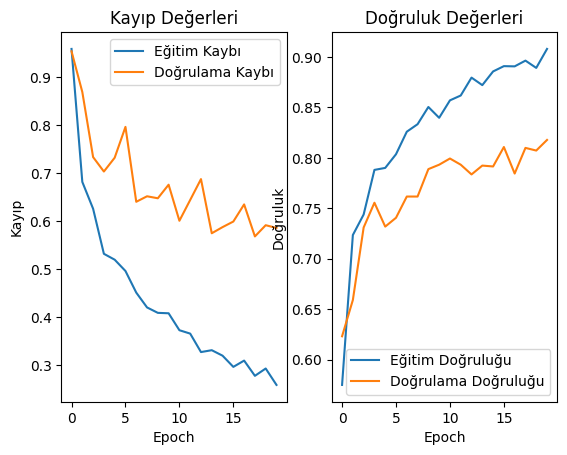

In [11]:
#kayıp (loss)
plt.Figure(figsize=(12, 4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
plt.title('Kayıp Değerleri')
plt.xlabel('Epoch')
plt.ylabel('Kayıp')
plt.legend()

# Doğruluk (accuracy)
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu')
plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu')
plt.title('Doğruluk Değerleri')
plt.xlabel('Epoch')
plt.ylabel('Doğruluk')
plt.legend()
plt.show()

In [12]:
#test seti ile değerlendirme
test_loss , test_accuracy = model.evaluate(test_gen, steps=len(test_gen))
print(f'Test Kaybı: {test_loss:.4f}, Test Doğruluğu: {test_accuracy:.4f}')

c:\Users\berat\anaconda3\envs\mp_env\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


41/41 ━━━━━━━━━━━━━━━━━━━━ 18s 442ms/step - accuracy: 0.8650 - loss: 0.4077
Test Kaybı: 0.4077, Test Doğruluğu: 0.8650


In [17]:
#Confusion Matrix ve Classification Report
from sklearn.metrics import classification_report , confusion_matrix
import numpy as np

#test seti tahminleri

y_pred = model.predict(test_gen)
# test_gen'deki tüm test görüntüleri için modelin tahminlerini alır
# Çıktı: her görüntü için sınıf olasılıklarını içeren bir array

y_pred_classes=np.argmax(y_pred,axis=1)
# Her tahmin için en yüksek olasılığa sahip sınıfın indeksini alır
# Bu, modelin sınıf tahmini olarak kullanılacak

y_true = test_gen.classes
# test_gen'deki gerçek etiketleri alır
# test_gen.classes, dizinler şeklinde (0,1,2,3) sınıf etiketlerini içerir

# Confusion Matrix
cm = confusion_matrix(y_true,y_pred_classes)
# Gerçek ve tahmin edilen sınıfları karşılaştırarak Confusion Matrix oluşturur
# Satırlar gerçek sınıfları, sütunlar tahmin edilen sınıfları gösterir

print("Confusion Matrix:\n", cm)  

# Classification Report
class_labels = list(test_gen.class_indices.keys())
# test_gen'deki sınıf isimlerini alır ve listeye çevirir
# Sırasıyla confusion matrix ve classification report için etiketler olacak

cr = classification_report(y_true,y_pred_classes,target_names=class_labels)
# Her sınıf için precision, recall, f1-score ve support değerlerini hesaplar
# target_names parametresi ile okunabilir sınıf isimleri ile gösterir

print("Classification Report:\n", cr)


41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step
Confusion Matrix:
 [[241  41   1  17]
 [ 17 196  61  32]
 [  2   1 402   0]
 [  3   2   0 295]]
Classification Report:
               precision    recall  f1-score   support

      glioma       0.92      0.80      0.86       300
  meningioma       0.82      0.64      0.72       306
     notumor       0.87      0.99      0.93       405
   pituitary       0.86      0.98      0.92       300

    accuracy                           0.86      1311
   macro avg       0.86      0.85      0.85      1311
weighted avg       0.86      0.86      0.86      1311



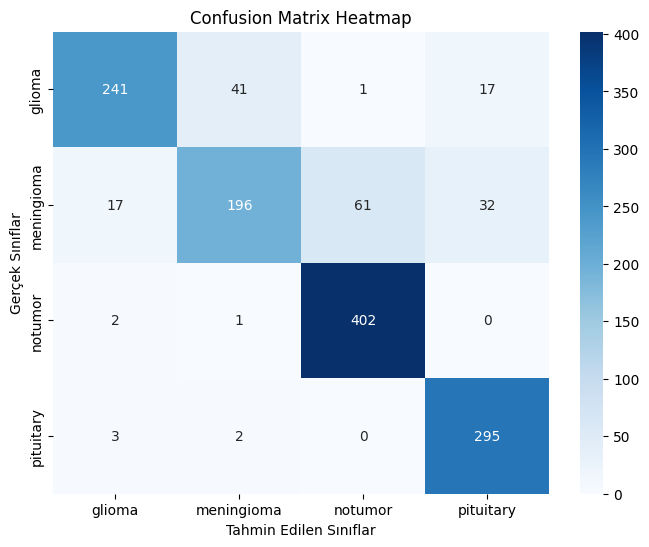

In [19]:
#Confusion Matrix Heatmap
import seaborn as sns

plt.figure(figsize=(8,6))  

sns.heatmap(cm,                # Görselleştirilecek veri: confusion matrix
            annot=True,        # Hücrelerin içine değerleri yazdırır
            fmt='d',           # Değerleri tam sayı (integer) formatında gösterir
            cmap='Blues',      # Renk haritası olarak mavi tonlarını kullanır
            xticklabels=class_labels, # X eksenine sınıf isimlerini ekler
            yticklabels=class_labels) # Y eksenine sınıf isimlerini ekler

plt.xlabel('Tahmin Edilen Sınıflar')  # X ekseni etiketi
plt.ylabel('Gerçek Sınıflar')         # Y ekseni etiketi
plt.title('Confusion Matrix Heatmap') # Grafik başlığı

plt.show()  # Grafiği ekranda gösterir


In [21]:
from tensorflow.keras.preprocessing import image
# Görüntü ön işleme

import tensorflow as tf
# TensorFlow kütüphanesi, derin öğrenme modelleri için

# Grad-CAM fonksiyonu
def get_grad_cam_heatmap(model,img_array,last_conv_layer_name,pred_index = None):
    """
    model: Eğitilmiş Keras modeli
    img_array: Tek bir görüntü (preprocess edilmiş)
    last_conv_layer_name: Modeldeki son convolutional layer'ın ismi
    pred_index: Hangi sınıf için Grad-CAM uygulanacak (default: modelin tahmini)
    """
    
    # Modelin son convolution layer'ını ve model çıktısını alacak şekilde yeni model oluştur
    grad_model = tf.keras.models.Model(
        [model.inputs],                      # Orijinal modelin input'u
        [model.get_layer(last_conv_layer_name).output, model.output]  # Son conv layer ve model çıktısı
    )

    # GradientTape ile gradyan hesaplama
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)  # İleri geçiş
        
        # Eğer hangi sınıf için Grad-CAM yapılacağı belirtilmemişse
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])         # Tahmin edilen sınıf
        class_channel = predictions[:, pred_index]          # İlgili sınıfın skoru
        
    # Conv layer çıktısı ile sınıf skorunun gradyanını hesapla
    grads = tape.gradient(class_channel, conv_outputs)
    
    # Gradyanları global average pooling ile ağırlıklandır
    pooled_grads = tf.reduce_mean(grads,axis=(0,1,2))
    # pooled_grads: her filtre için ağırlık (C boyutu)
    
    conv_outputs = conv_outputs[0]  # (H, W, C) batch boyutunu çıkar
    
    # Feature map ile ağırlıkları çarp ve topla
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis] # matris çarpımı
    heatmap = tf.squeeze(heatmap)  # Fazla boyutları at, HxW şeklinde olmalı

    # Normalize et: 0 ile 1 arasında
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()  # NumPy array olarak döndür

In [ ]:
for i, layer in enumerate(model.layers):
    try:
        print(i, layer.name, layer.output.shape) 
    except:
        print(i, layer.name, "Çıkış boyutu alınamadı")


0 conv2d_3 (None, 222, 222, 32)
1 max_pooling2d_3 (None, 111, 111, 32)
2 conv2d_4 (None, 109, 109, 64)
3 max_pooling2d_4 (None, 54, 54, 64)
4 conv2d_5 (None, 52, 52, 128)
5 max_pooling2d_5 (None, 26, 26, 128)
6 flatten_1 (None, 86528)
7 dense_2 (None, 128)
8 dropout_1 (None, 128)
9 dense_3 (None, 4)


In [24]:
# Model katmanları çıktısı:
# 0 conv2d_3       -> (None, 222, 222, 32)   : İlk Conv2D katmanı, 32 filtre, çıktı boyutu 222x222
# 1 max_pooling2d_3 -> (None, 111, 111, 32)  : Max pooling ile boyutu yarıya düşürdü
# 2 conv2d_4       -> (None, 109, 109, 64)   : İkinci Conv2D katmanı, 64 filtre
# 3 max_pooling2d_4 -> (None, 54, 54, 64)    : Max pooling ile boyutu yarıya düşürdü
# 4 conv2d_5       -> (None, 52, 52, 128)    : Son Conv2D katmanı, 128 filtre, Grad-CAM için kullanılacak
# 5 max_pooling2d_5 -> (None, 26, 26, 128)   : Max pooling
# 6 flatten_1      -> (None, 86528)          : Flatten, Dense katmanlara bağlanacak
# 7 dense_2        -> (None, 128)            : Fully connected layer
# 8 dropout_1      -> (None, 128)            : Dropout
# 9 dense_3        -> (None, 4)              : Çıkış katmanı, 4 sınıf


In [26]:
# Örnek kullanım
img, label = test_gen[0][0][0], test_gen[0][1][0]  # batch[0][0]: görüntü, batch[0][1]: label
img_array = np.expand_dims(img, axis=0)  # 1xHxWxC formatına çevir.

last_conv_layer_name = "conv2d_5" #son conv layerin adına baktık.

# Tek bir örnek ile modelin build edilmesini sağlıyoruz
_ = model(np.zeros((1, img_array.shape[1], img_array.shape[2], img_array.shape[3])))


In [33]:
# Son conv layer'ı bul
for layer in reversed(model.layers):
    if isinstance(layer, tf.keras.layers.Conv2D):
        last_conv_layer = layer
        break

print("Son Conv Layer:", last_conv_layer.name)


Son Conv Layer: conv2d_5


Son Conv Layer: conv2d_5


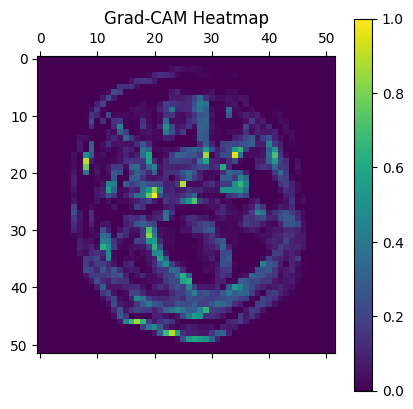

In [37]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Test görüntüsünü al
img, label = test_gen[0][0][0], test_gen[0][1][0]
img_array = np.expand_dims(img, axis=0)  # 1xHxWxC

# --- Son conv layer'ı bul ---
for layer in reversed(model.layers):
    if isinstance(layer, tf.keras.layers.Conv2D):
        last_conv_layer = layer
        break
print("Son Conv Layer:", last_conv_layer.name)

def get_grad_cam_heatmap_seq(model, img_array, last_conv_layer, pred_index=None):
    """
    Sequential model için Grad-CAM
    """
    with tf.GradientTape() as tape:
        x = img_array
        for layer in model.layers:
            x = layer(x)
            if layer == last_conv_layer:
                conv_outputs = x  # son Conv katmanı çıktısı
        predictions = x
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]
        tape.watch(conv_outputs)  # conv_outputs üzerinde gradient hesaplamayı izle

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)

    return heatmap.numpy()


# --- Heatmap oluştur ---
heatmap = get_grad_cam_heatmap_seq(model, img_array, last_conv_layer)

# --- Görselleştir ---
plt.matshow(heatmap)
plt.title("Grad-CAM Heatmap")
plt.colorbar()
plt.show()


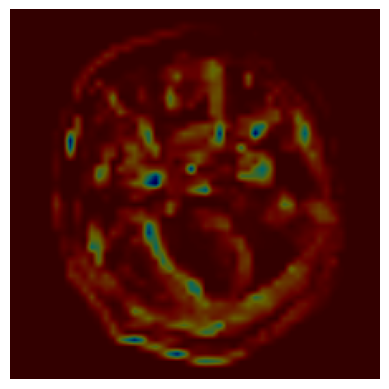

In [39]:
import cv2  # OpenCV kütüphanesi görüntü işleme işlemleri için

# Test görüntüsünü uint8 formatına çeviriyoruz (0-255 aralığına)
img_rgb = img.astype(np.uint8)

# Grad-CAM heatmap'ini orijinal görüntü boyutuna yeniden boyutlandırıyoruz
heatmap_resized = cv2.resize(heatmap, (img_rgb.shape[1], img_rgb.shape[0]))

# Heatmap'i renkli bir görselleştirme (Jet colormap) ile renklendiriyoruz
heatmap_colored = cv2.applyColorMap(np.uint8(255*heatmap_resized), cv2.COLORMAP_JET)

# Heatmap'i orijinal görüntü ile birleştiriyoruz (%40 ağırlık heatmap, %60 orijinal görüntü)
superimposed_img = heatmap_colored * 0.4 + img_rgb

# Sonuç görüntüsünü matplotlib ile gösteriyoruz
plt.imshow(superimposed_img.astype(np.uint8))
plt.axis('off')  # Eksenleri kapatıyoruz
plt.show()
